In [1]:
import torch 
from torch import nn
import torch.nn.functional as F
import math
import copy
import re 
import pytorch_lightning as pl
from torch.utils.data import DataLoader , Dataset
import torch.multiprocessing as mp
mp.set_start_method('spawn', force=True)
import nltk
from nltk.translate.bleu_score import corpus_bleu, sentence_bleu, SmoothingFunction

In [2]:
def preprocess_sentence(sentence):
    """This function preprocesses the sentence"""
    #lowercase the sentence
    sentence = sentence.lower()
    #split the sentence into word
    puntuations = r" !\"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~"
    sentence = re.sub(puntuations, r" \1 ", sentence)
    #replace continous numbers wiith <num>
    sentence = re.sub(r"\d+", "<num>", sentence)
    #replace multiple spaces with single space
    sentence = re.sub(r" +", " ", sentence)
    #split the sentence into words
    return sentence 
    

def preprocess_corpus(sentences , threshold = 5):
    """This function is for all sentences """
    
    word_freq = {}
    # first preprocess the sentences 
    tokenised_sentences = []
    for i , sentence in enumerate(sentences):
        #lowercase the sentence
        sentence = preprocess_sentence(sentence)
        #split the sentence into words
        words = sentence.split()
        tokenised_sentences.append(words)
        #count the frequency of each word
        for word in words:
            if word in word_freq:
                word_freq[word] += 1
            else:
                word_freq[word] = 1
    
    #remove the words with frequency less than threshold
    #replace the words with frequency less than threshold with <unk>
    vocab = ["<pad>" , "<sos>" , "<eos>" , "<unk>"]
    for i , sentence in enumerate(tokenised_sentences):
        for j , word in enumerate(sentence):
            if word_freq[word] < threshold:
                tokenised_sentences[i][j] = "<unk>"
    
    #create the vocab
    for word in word_freq:
        if word_freq[word] >= threshold:
            vocab.append(word)
            
    #create the word2idx and idx2word
    word2idx = {}
    idx2word = {}
    for i , word in enumerate(vocab):
        word2idx[word] = i
        idx2word[i] = word
    
    return  word2idx , idx2word , vocab 

In [3]:
# get the train and test sentences with labels 
data = {"train":{"en":[],"fr":[]},"test":{"en":[],"fr":[]},"dev":{"en":[],"fr":[]}}
for type in ["train" , "test" , "dev"]:
    for lang in ["en" , "fr"]:
        with open(f"../data/{type}.{lang}" , "r") as f:
            for line in f:
                data[type][lang].append(line.strip())
                
            

In [4]:
class Tokeniser():
    def __init__(self , word2idx , idx2word):
        self.word2idx = word2idx
        self.idx2word = idx2word
    
    def __call__(self , sentences, truncation = 100 , padding = True):
        """This function tokenises the sentence"""
        #first preprocess the sentences
        max_len = 0
        tokenised_sentences = []
        for sentence in sentences:
            #lowercase the sentence
            sentence = preprocess_sentence(sentence)
            #split the sentence into words
            words = sentence.split()
            tokenised_sentences.append(words)
            if len(tokenised_sentences[-1] ) > truncation-2:
                tokenised_sentences[-1] = tokenised_sentences[-1][:truncation]
                tokenised_sentences[-1]= ["<sos>"] + tokenised_sentences[-1] + ["<eos>"]
            else :
                tokenised_sentences[-1]= ["<sos>"] + tokenised_sentences[-1] + ["<eos>"]
            if len(tokenised_sentences[-1]) > max_len:
                max_len = len(tokenised_sentences[-1])
            
        
        #convert the words into indices
        indices, attention_mask = [] , []
        for sentence in tokenised_sentences:
            index = []
            for word in sentence:
                if word in self.word2idx:
                    index.append(self.word2idx[word])
                else:
                    index.append(self.word2idx["<unk>"])
            #pad the sentences
            
            if padding:
                
                index = index + [self.word2idx["<pad>"]] * (max_len - len(index))
            index = torch.tensor(index)
            indices.append(index)
        
        
        #create the attention mask
        for index in indices:
            attention_mask.append(torch.where(index == self.word2idx["<pad>"] , 0 , 1))
        
        #convert the indices into tensor
        indices = torch.stack(indices)
        attention_mask = torch.stack(attention_mask)
        return indices , attention_mask
        
        
    def decode(self , indices):
        """This function decodes the indices into words"""
        words = []
        for index in indices:
            words.append(self.idx2word[index])
        return words
    
    

In [5]:
english_corpus = data["train"]["en"] + data["dev"]["en"]
french_corpus = data["train"]["fr"] + data["dev"]["fr"]

en_word2idx , en_idx2word , en_vocab = preprocess_corpus(english_corpus, threshold = 5)
fr_word2idx , fr_idx2word , fr_vocab = preprocess_corpus(french_corpus , threshold = 5)



In [6]:
en_tokeniser = Tokeniser(en_word2idx , en_idx2word)
fr_tokeniser = Tokeniser(fr_word2idx , fr_idx2word)

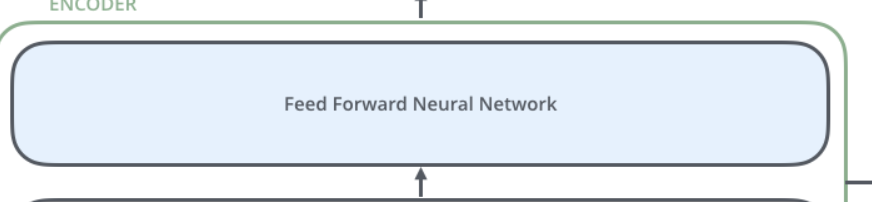

In [7]:
class FeedForward(nn.Module):
    def __init__(self , d_model , d_ff , dropout = 0.1):
        super().__init__()
        self.linear1 = nn.Linear(d_model , d_ff)
        self.linear2 = nn.Linear(d_ff , d_model)
        self.dropout = nn.Dropout(dropout)
    
    def forward(self , x):
        x = self.linear1(x)
        x = F.relu(x)
        x = self.dropout(x)
        x = self.linear2(x)
        return x
    

In [8]:
class MultiHeadAttention(nn.Module):
    def __init__(self , d_model , num_heads , dropout = 0.1):
        super().__init__()
        assert d_model % num_heads == 0
        self.d_model = d_model
        self.num_heads = num_heads
        self.dropout = nn.Dropout(dropout)
        self.d_k = d_model // num_heads
        self.linear_q = nn.Linear(d_model , d_model)
        self.linear_k = nn.Linear(d_model , d_model)
        self.linear_v = nn.Linear(d_model , d_model)
        self.linear_o = nn.Linear(d_model , d_model)
    
    def forward(self , query , key , value , mask = None):
        batch_size = query.size(0)
        #query = [batch_size , seq_len , d_model]
        #key = [batch_size , seq_len , d_model]
        #value = [batch_size , seq_len , d_model]
        #mask = [batch_size , seq_len , seq_len]
        
        #linear transformation
        query = self.linear_q(query)
        key = self.linear_k(key)
        value = self.linear_v(value)
        #query = [batch_size , seq_len , d_model]
        #key = [batch_size , seq_len , d_model]
        #value = [batch_size , seq_len , d_model]
        
        #split the query , key and value into num_heads
        query = query.view(batch_size , -1 , self.num_heads , self.d_k)
        key = key.view(batch_size , -1 , self.num_heads , self.d_k)
        value = value.view(batch_size , -1 , self.num_heads , self.d_k)
        #query = [batch_size , seq_len , num_heads , d_k]
        #key = [batch_size , seq_len , num_heads , d_k]
        #value = [batch_size , seq_len , num_heads , d_k]
        
        #transpose the query , key and value
        query = query.transpose(1 , 2)
        key = key.transpose(1 , 2)
        value = value.transpose(1 , 2)
        #query = [batch_size , num_heads , seq_len , d_k]
        #key = [batch_size , num_heads , seq_len , d_k]
        #value = [batch_size , num_heads , seq_len , d_k]
        
        #calculate the scores
        scores = torch.matmul(query , key.transpose(-2 , -1))
        #scores = [batch_size , num_heads , seq_len , seq_len]
        
        #scale the scores
        scores = scores / math.sqrt(self.d_k)

        #apply softmax
        if mask is not None:
            
            mask = mask.unsqueeze(1)
            mask = mask.expand_as(scores)
            mask.to(scores.device)
            scores = scores.masked_fill(mask == 0 , -1e9)
            
        scores = F.softmax(scores , dim = -1)
        scores = self.dropout(scores)
        #scores = [batch_size , num_heads , seq_len , seq_len]
        
        #apply attention
        context = torch.matmul(scores , value)
        #context = [batch_size , num_heads , seq_len , d_k]
        
        #concat the heads
        context = context.transpose(1 , 2)
        #context = [batch_size , seq_len , num_heads , d_k]
        context = context.contiguous().view(batch_size , -1 , self.d_model)
        #context = [batch_size , seq_len , d_model]
        
        #linear transformation
        context = self.linear_o(context)
        #context = [batch_size , seq_len , d_model]
        return context

        

In [9]:
class LayerNorm(nn.Module):
    def __init__(self , d_model , eps = 1e-6):
        super().__init__()
        self.d_model = d_model
        self.eps = eps
        self.a_2 = nn.Parameter(torch.ones(self.d_model))
        self.b_2 = nn.Parameter(torch.zeros(self.d_model))
    
    def forward(self , x):
        mean = x.mean(-1 , keepdim = True)
        std = x.std(-1 , keepdim = True)
        return self.a_2 * (x - mean) / (std + self.eps) + self.b_2

In [10]:
class EncoderLayer(nn.Module):
    def __init__(self, d_model , num_heads , d_ff , num_layers , dropout = 0.1):
        super().__init__()
        self.d_model = d_model
        self.num_heads = num_heads
        self.d_ff = d_ff
        self.num_layers = num_layers
        self.dropout = nn.Dropout(dropout)
        self.multi_head_attention = MultiHeadAttention(d_model , num_heads , dropout)
        self.feed_forward = FeedForward(d_model , d_ff , dropout)
        self.layer_norm1 = LayerNorm(d_model)
        self.layer_norm2 = LayerNorm(d_model)
        
    def forward(self , x , mask = None):
        batch, seq_len, d_model = x.size()
        if mask is not None: 
            mask = mask.unsqueeze(1)
            mask = mask.expand(batch, seq_len, seq_len)
        
        x_m = self.multi_head_attention(x , x , x , mask)
        x = self.dropout(x)
        x = self.layer_norm1(x + x_m)
        x_f = self.feed_forward(x)
        x = self.dropout(x)
        x = self.layer_norm2(x + x_f)
        return x
    
        
        #x = [batch_size , seq_len , d_model]
        #mask = [batch_size , seq_len , seq_len]
        
            
        

In [11]:
class DecoderLayer(nn.Module):
    def __init__(self, d_model , num_heads , d_ff , num_layers , dropout = 0.1):
        super().__init__()
        self.d_model = d_model
        self.num_heads = num_heads
        self.d_ff = d_ff
        self.num_layers = num_layers
        self.dropout = nn.Dropout(dropout)
        self.multi_head_attention1 = MultiHeadAttention(d_model , num_heads , dropout)
        self.multi_head_attention2 = MultiHeadAttention(d_model , num_heads , dropout)
        self.feed_forward = FeedForward(d_model , d_ff , dropout)
        self.layer_norm1 = LayerNorm(d_model)
        self.layer_norm2 = LayerNorm(d_model)
        self.layer_norm3 = LayerNorm(d_model)
    
    def forward(self , x , encoder_output,src_mask=None ,tgt_mask = None):
        #x = [batch_size , seq_len , d_model]
        #encoder_output = [batch_size , seq_len , d_model]
        #src_mask = [batch_size , seq_len ]
        batch_size = x.size(0)
        seq_len = x.size(1)
        look_ahead_mask = torch.tril(torch.ones(x.size(1) , x.size(1))).unsqueeze(0)
        look_ahead_mask = look_ahead_mask.to(x.device)
        x_m = self.multi_head_attention1(x , x , x , look_ahead_mask)
        x = self.dropout(x)
        x = self.layer_norm1(x + x_m)
        cross_mask = src_mask.unsqueeze(1).expand(batch_size , seq_len , src_mask.size(1)) 
        cross_mask = cross_mask.to(x.device)
        x_m = self.multi_head_attention2(x , encoder_output , encoder_output , cross_mask)
        x = self.dropout(x)
        x = self.layer_norm2(x + x_m)
        x_f = self.feed_forward(x)
        x = self.dropout(x)
        x = self.layer_norm3(x + x_f)
        return x
    
        
        
    
        
      

In [12]:
class Encoder(nn.Module):
    def __init__(self , d_model , num_heads , d_ff , num_layers , dropout = 0.1 , en_embedding = None):
        super().__init__()
        self.d_model = d_model
        self.num_heads = num_heads
        self.d_ff = d_ff
        self.num_layers = num_layers
        self.dropout = nn.Dropout(dropout)
        self.layers = nn.ModuleList([EncoderLayer(d_model , num_heads , d_ff , num_layers , dropout) for _ in range(num_layers)])
        self.en_embedding = en_embedding
    
    def forward(self , x , mask = None):
        x = self.en_embedding(x)
        for layer in self.layers:
            x = layer(x , mask)
        return x
    
class Decoder(nn.Module):
    def __init__(self , d_model , num_heads , d_ff , num_layers , dropout = 0.1 , fr_embedding = None):
        super().__init__()
        self.d_model = d_model
        self.num_heads = num_heads
        self.d_ff = d_ff
        self.num_layers = num_layers
        self.fr_embedding = fr_embedding
        self.dropout = nn.Dropout(dropout)
        self.layers = nn.ModuleList([DecoderLayer(d_model , num_heads , d_ff , num_layers , dropout) for _ in range(num_layers)])
    
    def forward(self , x , encoder_output , src_mask = None , tgt_mask = None):
        x = self.fr_embedding(x)
        for layer in self.layers:
            x = layer(x , encoder_output , src_mask , tgt_mask)
        return x
    
    
    

In [13]:
class Transformer(nn.Module):
    def __init__(self , d_model , num_heads , d_ff , num_layers , dropout = 0.1 , en_vocab = en_vocab , fr_vocab = fr_vocab):
        super().__init__()
        self.d_model = d_model
        self.num_heads = num_heads
        self.d_ff = d_ff
        self.num_layers = num_layers
        self.dropout = nn.Dropout(dropout)
        self.en_embedding = nn.Embedding(len(en_vocab) , d_model)
        self.fr_embedding = nn.Embedding(len(fr_vocab) , d_model)
        self.encoder = Encoder(d_model , num_heads , d_ff , num_layers , dropout, self.en_embedding)
        self.decoder = Decoder(d_model , num_heads , d_ff , num_layers , dropout, self.fr_embedding)
        self.linear = nn.Linear(d_model , len(fr_vocab))
    
    def forward(self , src , tgt , src_mask = None , tgt_mask = None):
        
        encoder_output = self.encoder(src , src_mask)
        decoder_output = self.decoder(tgt , encoder_output , src_mask , tgt_mask)
        
        output = self.linear(decoder_output)
        return output
    
    def translate(self , src , src_mask = None , max_len = 100):
        
        encoder_output = self.encoder(src , src_mask)
        tgt = torch.zeros(src.size(0) , 1).long().to(src.device)
        for i in range(max_len):
            tgt_mask = torch.tril(torch.ones(tgt.size(1) , tgt.size(1))).unsqueeze(0).to(src.device)
            decoder_output = self.decoder(tgt , encoder_output , src_mask , tgt_mask)
            output = self.linear(decoder_output)
            output = output[: , -1 , :]
            output = torch.argmax(output , dim = -1)
            tgt = torch.cat([tgt , output.unsqueeze(1)] , dim = 1)
        return tgt
    

In [14]:
#Hyperparameters
d_model = 300
num_heads = 6
d_ff = 300
num_layers = 2
dropout = 0.3
batch_size = 16
epochs = 40
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)


cuda


In [15]:
en_input_ids , en_attention_mask = en_tokeniser(data["train"]["en"])
fr_input_ids , fr_attention_mask = fr_tokeniser(data["train"]["fr"])

In [16]:
class TranslationDataset(Dataset):
    def __init__(self , en_input_ids , en_attention_mask , fr_input_ids , fr_attention_mask):
        self.en_input_ids = en_input_ids
        self.en_attention_mask = en_attention_mask
        self.fr_input_ids = fr_input_ids
        self.fr_attention_mask = fr_attention_mask
    
    def __len__(self):
        return len(self.en_input_ids)
    
    def __getitem__(self , idx):
        return ((self.en_input_ids[idx] , self.en_attention_mask[idx]) , (self.fr_input_ids[idx] , self.fr_attention_mask[idx]))

In [17]:
train_dataset = TranslationDataset(en_input_ids , en_attention_mask , fr_input_ids , fr_attention_mask)
en_input_ids_dev, en_attention_mask_dev = en_tokeniser(data["dev"]["en"])
fr_input_ids_dev, fr_attention_mask_dev = fr_tokeniser(data["dev"]["fr"])
dev_dataset = TranslationDataset(en_input_ids_dev , en_attention_mask_dev , fr_input_ids_dev , fr_attention_mask_dev)
en_input_ids_test, en_attention_mask_test = en_tokeniser(data["test"]["en"])
fr_input_ids_test, fr_attention_mask_test = fr_tokeniser(data["test"]["fr"])
test_dataset = TranslationDataset(en_input_ids_test , en_attention_mask_test , fr_input_ids_test , fr_attention_mask_test)


In [18]:
dataloaders= {"train":DataLoader(train_dataset , batch_size = batch_size , shuffle = True , ) , "test" : DataLoader(test_dataset , batch_size = batch_size , shuffle = False , ) , "dev":DataLoader(dev_dataset , batch_size = batch_size , shuffle = False ,)}

In [19]:
class LitDataset(pl.LightningDataModule):
    def __init__(self , dataloaders):
        super().__init__()
        self.dataloaders = dataloaders
    
    def train_dataloader(self):
        return self.dataloaders["train"]
    
    def val_dataloader(self):
        return self.dataloaders["dev"]
    
    def test_dataloader(self):
        return self.dataloaders["test"]

In [20]:
class LitTransformer(pl.LightningModule):
    def __init__(self, d_model , num_heads , d_ff , num_layers , dropout , en_vocab , fr_vocab):
        super().__init__()
        self.d_model = d_model
        self.num_heads = num_heads
        self.d_ff = d_ff
        self.num_layers = num_layers
        self.dropout = dropout
        self.en_vocab = en_vocab
        self.fr_vocab = fr_vocab
        self.transformer = Transformer(d_model , num_heads , d_ff , num_layers , dropout , en_vocab , fr_vocab)
        self.criterion = nn.CrossEntropyLoss(ignore_index = self.fr_vocab.index("<pad>"))
        
    def forward(self , src , tgt , src_mask = None , tgt_mask = None):
        return self.transformer(src , tgt , src_mask , tgt_mask)
    
    def training_step(self , batch , batch_idx):
        src , tgt = batch
        src_input_ids , src_attention_mask = src
        tgt_input_ids , tgt_attention_mask = tgt
        output = self(src_input_ids , tgt_input_ids[:,:-1] , src_attention_mask , tgt_attention_mask[:,:-1])
        output = output.contiguous().view(-1 , output.size(-1))
        tgt_input_ids = tgt_input_ids[:,1:].contiguous().view(-1)
        loss = self.criterion(output , tgt_input_ids)
        self.log("train_loss" , loss)
        return loss
    
    def validation_step(self , batch , batch_idx):
        src , tgt = batch
        src_input_ids , src_attention_mask = src
        tgt_input_ids , tgt_attention_mask = tgt
        output = self(src_input_ids , tgt_input_ids[:,:-1] , src_attention_mask , tgt_attention_mask[:,:-1])
        output = output.contiguous().view(-1 , output.size(-1))
        tgt_input_ids = tgt_input_ids[:,1:].contiguous().view(-1)
        loss = self.criterion(output , tgt_input_ids)
        self.log("val_loss" , loss)
        return loss
    
    def test_step(self , batch , batch_idx):
        src , tgt = batch
        src_input_ids , src_attention_mask = src
        tgt_input_ids , tgt_attention_mask = tgt
        output = self(src_input_ids , tgt_input_ids[:,:-1] , src_attention_mask , tgt_attention_mask[:,:-1])
        output = output.contiguous().view(-1 , output.size(-1))
        tgt_input_ids = tgt_input_ids[:,1:].contiguous().view(-1)
        loss = self.criterion(output , tgt_input_ids)
        self.log("test_loss" , loss)
        return loss
    
    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters() , lr = 0.0001)
    
    def translate(self , src , src_mask = None , max_len = 100):
        return self.transformer.translate(src , src_mask , max_len)
    
    
model = LitTransformer(d_model , num_heads , d_ff , num_layers , dropout , en_vocab , fr_vocab)

trainer = pl.Trainer(max_epochs=epochs  , enable_progress_bar=True, logger=None ,devices =1) 

/home2/jainit/miniconda3/envs/torchy/lib/python3.11/site-packages/lightning_fabric/plugins/environments/slurm.py:168: PossibleUserWarning: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home2/jainit/miniconda3/envs/torchy/lib/python3.11/ ...
  rank_zero_warn(
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [21]:
trainer.fit(model , LitDataset(dataloaders))

/home2/jainit/miniconda3/envs/torchy/lib/python3.11/site-packages/lightning_fabric/plugins/environments/slurm.py:168: PossibleUserWarning: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home2/jainit/miniconda3/envs/torchy/lib/python3.11/ ...
  rank_zero_warn(
/home2/jainit/miniconda3/envs/torchy/lib/python3.11/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:617: UserWarning: Checkpoint directory /home2/jainit/LR_LLM/Transformer/src/lightning_logs/version_1000421/checkpoints exists and is not empty.
  rank_zero_warn(f"Checkpoint directory {dirpath} exists and is not empty.")
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name        | Type             | Params
-------------------------------------------------
0 | transformer | Transformer      | 10.7 M
1 | criterion   | CrossEntropyLoss | 0     
---------------------------------------------

Sanity Checking: 0it [00:00, ?it/s]

/home2/jainit/miniconda3/envs/torchy/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:442: PossibleUserWarning: The dataloader, val_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 40 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/home2/jainit/miniconda3/envs/torchy/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:442: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 40 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

In [ ]:
# # training using normal pytorch
# model = Transformer(d_model , num_heads , d_ff , num_layers , dropout , en_vocab , fr_vocab)
# model = model.to(device)
# optimizer = torch.optim.Adam(model.parameters() , lr = 1e-4)
# criterion = nn.CrossEntropyLoss(ignore_index = fr_word2idx["<pad>"])
# scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer , patience = 2 , verbose = True)

# def train(model , optimizer , criterion , scheduler , dataloaders , epochs , device):
#     steps = 0
#     for epoch in range(epochs):
#         for phase in ["train" , "dev"]:
#             if phase == "train":
#                 model.train()
#             else:
#                 model.eval()
#             epoch_loss = 0
#             for ((en_input_ids , en_attention_mask) , (fr_input_ids , fr_attention_mask)) in dataloaders[phase]:
#                 steps += 1
#                 en_input_ids = en_input_ids.to(device)
#                 en_attention_mask = en_attention_mask.to(device)
#                 fr_input_ids = fr_input_ids.to(device)
#                 fr_attention_mask = fr_attention_mask.to(device)
#                 optimizer.zero_grad()
#                 with torch.set_grad_enabled(phase == "train"):
#                     output = model(en_input_ids , fr_input_ids[:,:-1] , en_attention_mask , fr_attention_mask[:,:-1])
#                     output = output.contiguous().view(-1 , output.size(-1))
#                     fr_input_ids = fr_input_ids[:,1:].contiguous().view(-1)
#                     loss = criterion(output , fr_input_ids)
#                     if phase == "train":
#                         loss.backward()
#                         optimizer.step()
#                 epoch_loss += loss.item()
#                 if steps % 100 == 0:
#                     print(f"Epoch : {epoch+1} , Phase : {phase} , Loss : {loss.item()}")
#             epoch_loss = epoch_loss / len(dataloaders[phase])
#             if phase == "train":
#                 print(f"Epoch : {epoch+1} , Train Loss : {epoch_loss}")
#             else:
#                 print(f"Epoch : {epoch+1} , Dev Loss : {epoch_loss}")
#                 scheduler.step(epoch_loss)

In [ ]:
# train(model , optimizer , criterion , scheduler , dataloaders , epochs , device)